### SHAP Examples 
This notebook covers the main plots of SHAP values 

In [20]:
import numpy as np
import pandas as pd
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### Data
Let's use FIFA data to predict if an award `Man of the Match` is going to appear in the end of a game.

In [39]:
data = pd.read_csv('data/fifa_2018_statistics.csv')
data.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


In [40]:
# create a target variable 
data['Man of the Match'] == "Yes"

# select only numeric features for simplicity
feature_names = [
    i for i in data.columns if data[i].dtype in [np.int64, np.int64]
]

# select features and dependent variable
X, y = data[feature_names], data['Man of the Match']

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [41]:
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [45]:
# let's see predicted probability for a random observation
indx = 5
feature_vector = X_test.iloc[indx].values.reshape(1, -1)

model.predict_proba(feature_vector)

array([[0.29, 0.71]])

### SHAP Explainer
SHAP library has many explainers available. In most cases the following explainers might be used:
- `LinearExplainer`: linear models 
- `TreeExplainer`: non-linear models
- `Explainer`: any model
- `DeepExplainer`: DL models

**Recomendation**

Always choose a proper Explainer for your model because the optimization is better and SHAP values will be calculated much faster. For example, we could have used `TreeExplainer` and `KernelExplainer`. Both explainers would work, however, `KernelExplainer` would be slower and obtained SHAP values would be different since `KernelExplainer` uses approximation.

More info: https://shap.readthedocs.io/en/latest/api.html#explainers

In [102]:
# 1. define explainer
explainer = shap.TreeExplainer(model)

**Important**
- We must define what we would like to explain: predicted probability, log loss, etc.
- Use approximation if have much data (faster computation but biased SHAP values)

In [103]:
# 2. calculate SHAP values (either one observation or all)
shap_values = explainer.shap_values(feature_vector)

**Important**
- Test data (matrix or single vector is usually used)
- Use `y` only in case of Loss explanation
- Use approximation if have much data (faster computation but biased SHAP values)

For classification problesm `shap_values` is a list of arrays with the following shape
- `n_classes * n_samples * n_features`

**Binary Classification Example**

The `shap_values` is a **list with two arrays:**
- Firt array -> SHAP values for negative outcome (in our case, no award)
- Second array -> SHAP values for positive outcome (will be the award)

In [104]:
print('Feature Vector Dimension: ', feature_vector.shape)
print('SHAP (First Array) Dimension: ', shap_values[0].shape)
print('SHAP (Second Array) Dimension: ', shap_values[1].shape)

Feature Vector Dimension:  (1, 18)
SHAP (First Array) Dimension:  (1, 18)
SHAP (Second Array) Dimension:  (1, 18)


In [105]:
# 2.1 shap values for all observations in test data
shap_values = explainer.shap_values(X_test)

In [106]:
print('SHAP (First Array) Dimension: ', shap_values[0].shape)
print('SHAP (Second Array) Dimension: ', shap_values[1].shape)

SHAP (First Array) Dimension:  (32, 18)
SHAP (Second Array) Dimension:  (32, 18)


- When passing all data it returns an array of shape (n_samples * n_features)

### SHAP Plots
Many different plots that explain the dependency can be used:
- Bar
- Waterfall
- force
...

More info: https://shap.readthedocs.io/en/latest/api.html#plots

**Force Plot**

In [110]:
expected_value = explainer.expected_value[1]

In [111]:
# all samples
shap.initjs()

shap.force_plot(
    base_value=expected_value,
    shap_values=shap_values[1],
    features=X_test,
    feature_names=X_test.columns
)

In [115]:
# single sampple
shap_values = explainer.shap_values(feature_vector)

In [116]:
shap.force_plot(
    base_value=expected_value,
    shap_values=shap_values[1],
    features=feature_vector,
    feature_names=X_test.columns
)

**Interpretation**
- `Goal Scored` is the most important positive feature
- `Ball Possession` is the most important negative feature
- If we substract length of a red line with a blue line, we get the predicted value `f(x)`

**Summary Plot**

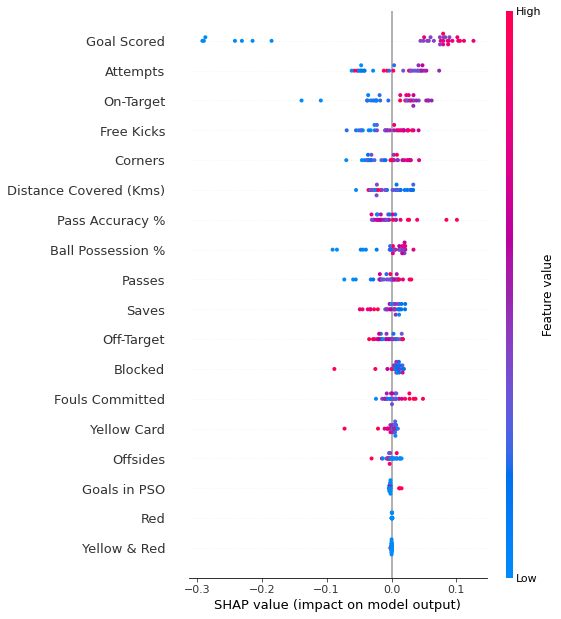

In [121]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

**Interpretation**

We use `shap_values[1]` because we would like to understand the following: **"How eah observation contribute to the positve outcome -> positive class"**
- We see that the most important features: `Goal Scored`, `Attempts` and `On-Target`
- Higher values of `Goal Scored` lead to higher probability of having an award. The opposite is also true
- `Red`and `Yellow and Red` are useless and don't contribute

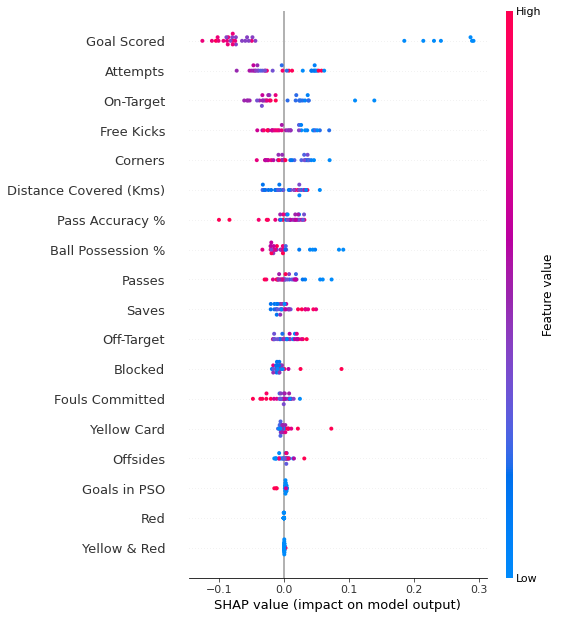

In [122]:
# interpretation for negative class
shap.summary_plot(shap_values[0], X_test)

**Decision Plot**

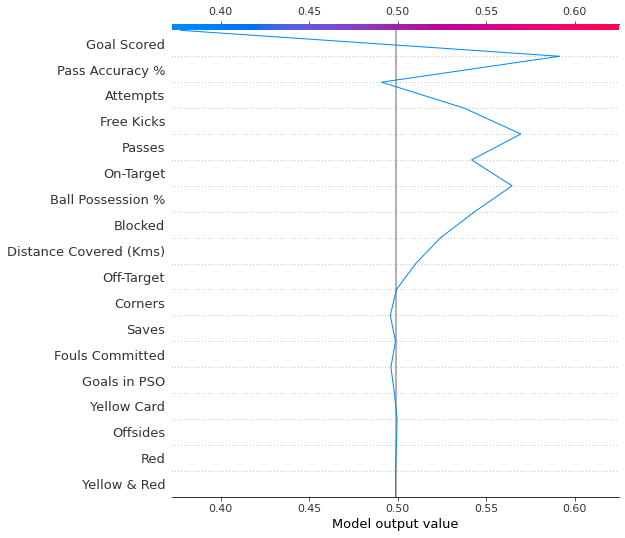

In [123]:
# single observation
expected_value = explainer.expected_value[0]
shap.decision_plot(expected_value, shap_values[1][0], X_train.columns)

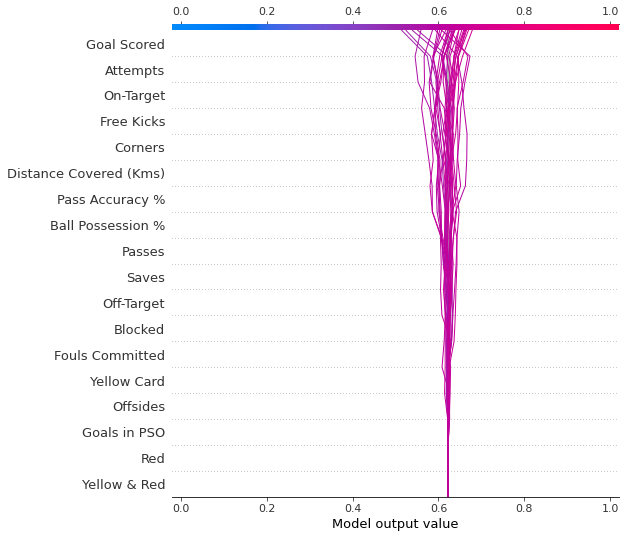

In [124]:
# multiple observations + log scale
expected_value = explainer.expected_value[0]
shap.decision_plot(expected_value, shap_values[1], X_train.columns, link='logit')

**Bar Plot**

In [142]:
# todo

**Dependence Plot**

In [141]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

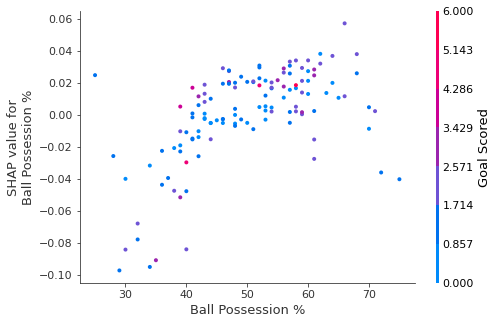

In [137]:
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")